In [ ]:

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install scikit-plot


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from sklearn.metrics import accuracy_score
import nltk
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec,doc2vec
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, confusion_matrix
import scikitplot as skplt
import umap
from sklearn import metrics,utils
import re
%matplotlib inline

In [ ]:
base_path = '/content/************/'
train = pd.read_csv('/content/******************/train.csv')
train = train[['Articles','Yazar']]
train = train[pd.notnull(train['Articles'])]

test = pd.read_csv('/content/******************/test.csv')
test = test[['Articles','Yazar']]
test = test[pd.notnull(test['Articles'])]



In [ ]:
def cleanText(input_sentence):
 
  tmp= [word.replace('I','ı') for word in input_sentence.split(' ')]
  tmp= [word.lower() for word in tmp]
  tmp= [word.replace('i̇','i') for word in tmp]
  tmp = [re.sub('[^A-Za-z0-9ğüşıçöiâî]+', ' ', word) for word in tmp]
  tmp = [word.strip(' ') for word in tmp]
  tmp1 =' '.join(tmp)

  return tmp1

In [ ]:
train['Articles']=train['Articles'].apply(cleanText)
test['Articles']=test['Articles'].apply(cleanText)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


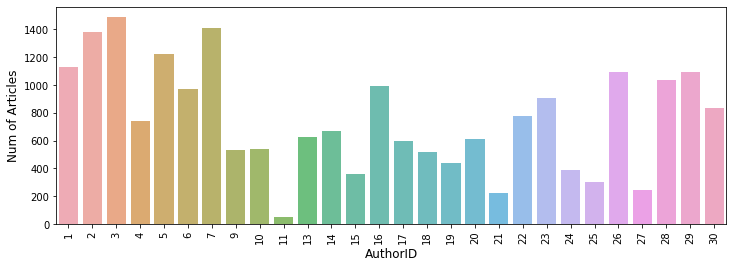

In [ ]:
cnt_pro = train['Yazar'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Articles', fontsize=12)
plt.xlabel('AuthorID', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [ ]:

nltk.download('punkt')
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['Articles']), tags=[r.Yazar]), axis=1)

In [ ]:
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['Articles']), tags=[r.Yazar]), axis=1)

In [ ]:

tr_tags = [i.tags[0] for i in train_tagged]
te_tags = [i.tags[0] for i in test_tagged] 

Logistic Regression Results

In [ ]:
def LogReg_Results(train_embeddings,test_embeddings):
  logreg = LogisticRegression(n_jobs=cores, C = 10000, max_iter=10000, tol = 1e-5)
  logreg.fit(train_embeddings, tr_tags)    
  te_tags_predicted = logreg.predict(test_embeddings)
  tr_tags_predicted = logreg.predict(train_embeddings)

  print('Train accuracy %s' % accuracy_score(tr_tags, tr_tags_predicted))
  print('Testing accuracy %s' % accuracy_score(te_tags, te_tags_predicted))
  print('Testing Log-Reg F1 weighted score: {}'.format(f1_score(te_tags, te_tags_predicted, average='weighted')))
  print('Testing Log-Reg F1 macro score: {}'.format(f1_score(te_tags, te_tags_predicted, average='macro')))
  print('Testing Log-Reg F1 macro score class-based:: {}'.format(f1_score(te_tags, te_tags_predicted, average=None)))

SVC Results

In [ ]:
def SVC_Results(train_embeddings,test_embeddings):
  clf = SVC(kernel='linear', C=1).fit(train_embeddings, tr_tags)
  clf_te_tags_predicted = clf.predict(test_embeddings)    
  clf_tr_tags_predicted = clf.predict(train_embeddings)
  
  print('C-SVC Train Score %s\n'%clf.score(train_embeddings, tr_tags))
  print('C-SVC Test Score %s\n'%clf.score(test_embeddings, te_tags))
  print('Testing C-SVC F1 weighted score: {}'.format(f1_score(te_tags, clf_te_tags_predicted, average='weighted')))
  print('Testing C-SVC F1 macro score: {}'.format(f1_score(te_tags, clf_te_tags_predicted, average='macro')))
  print('Testing C-SVC F1 macro score class-based:: {}'.format(f1_score(te_tags, clf_te_tags_predicted, average=None)))


Model Training 

In [ ]:
cores = multiprocessing.cpu_count()
for dm in [0,1]:
  for vs in [5,10,15,30,50,75,100,125,150,175,200,250,350,500,650,750,1000]:
    for epoch in [1,2,3,4,5,6,7,8,9,10,11,12]:
      print('\n','setting : ','dm : ', dm, 'vs : ', vs, 'num epochs : ', epoch)
      model_dm = Doc2Vec(dm=dm, vector_size=vs, window=10, negative=5, min_count=1, workers=cores, alpha=0.0061, min_alpha = 0.0001)
      model_dm.build_vocab([x for x in tqdm(train_tagged.values)])

      for ep in range(epoch):
        model_dm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dm.alpha -= 0.0012
        model_dm.min_alpha = model_dm.alpha
      
      train_embeddings = [] 
      for i in train_tagged:
        embedding = model_dm.infer_vector(i.words, steps=20, alpha = 0.005)
        train_embeddings.append(embedding)        

      test_embeddings = [] 
      for i in test_tagged:
        embedding = model_dm.infer_vector(i.words, steps=20, alpha = 0.005)
        test_embeddings.append(embedding)     

      LogReg_Results(train_embeddings,test_embeddings)
      SVC_Results(train_embeddings,test_embeddings)
      
      for i in [te_tags_predicted,clf_te_tags_predicted]:
        skplt.metrics.plot_confusion_matrix(te_tags, i, normalize=True,figsize=(15,15))
        plt.show()